# NBA Predictor - Feature Inspection

This notebook provides comprehensive analysis of the 21 engineered features from the v1.1 implementation.

**Goals:**
1. Load and inspect feature-engineered train/test datasets
2. Perform sanity checks (NaNs, ranges, distributions)
3. Analyze correlation with target label (home_win)
4. Create correlation matrix between key features
5. Visualize feature "usefulness" (e.g., win rate vs binned feature values)
6. (Optional) Connect to v1.1 best model for calibration/error analysis

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import sys
sys.path.append('../src')

from nba_predictor import config

%matplotlib inline
sns.set_style('darkgrid')

print(f"Random seed: {config.RANDOM_SEED}")

Random seed: 42


### Load Feature-Engineered Data

In [8]:
train_df = pd.read_parquet(config.TRAIN_FEATURES_FILE)
test_df = pd.read_parquet(config.TEST_FEATURES_FILE)

print(f"Train: {len(train_df):,} games")
print(f"Test:  {len(test_df):,} games")
print(f"\nDate range:")
print(f"  Train: {train_df[config.GAME_DATE_COL].min()} to {train_df[config.GAME_DATE_COL].max()}")
print(f"  Test:  {test_df[config.GAME_DATE_COL].min()} to {test_df[config.GAME_DATE_COL].max()}")

Train: 21,238 games
Test:  5,314 games

Date range:
  Train: 2003-10-05 00:00:00 to 2018-12-13 00:00:00
  Test:  2018-12-14 00:00:00 to 2022-12-22 00:00:00


## 2. Feature Overview & Sanity Checks

### 2.1 Feature Groups Summary

In [9]:
print("Feature Groups:")
for group_name, features in config.FEATURE_GROUPS.items():
    print(f"\n{group_name.upper()}: {len(features)} features")
    print(f"  {features}")

Feature Groups:

BASELINE: 2 features
  ['HOME_TEAM_ID', 'VISITOR_TEAM_ID']

SEASON: 1 features
  ['SEASON']

ROLLING_RECORD: 2 features
  ['home_win_pct_L10', 'away_win_pct_L10']

ROLLING_PERFORMANCE: 8 features
  ['home_fg_pct_L10', 'away_fg_pct_L10', 'home_fg3_pct_L10', 'away_fg3_pct_L10', 'home_ft_pct_L10', 'away_ft_pct_L10', 'home_pt_diff_L10', 'away_pt_diff_L10']

REST: 4 features
  ['home_rest_days', 'away_rest_days', 'home_back_to_back', 'away_back_to_back']

STREAK: 2 features
  ['home_win_streak', 'away_win_streak']

H2H: 2 features
  ['home_h2h_win_pct', 'home_h2h_pt_diff']


### 2.2 Missing Values Analysis


Missing Values Summary:
             Feature  Train_NaN_Count  Train_NaN_Pct  Test_NaN_Count  \
3   home_win_pct_L10               20       0.094171               0   
4   away_win_pct_L10               10       0.047085               0   
5    home_fg_pct_L10               20       0.094171               0   
6    away_fg_pct_L10               10       0.047085               0   
7   home_fg3_pct_L10               20       0.094171               0   
8   away_fg3_pct_L10               10       0.047085               0   
9    home_ft_pct_L10               20       0.094171               0   
10   away_ft_pct_L10               10       0.047085               0   
11  home_pt_diff_L10               20       0.094171               0   
12  away_pt_diff_L10               10       0.047085               0   

    Test_NaN_Pct  
3            0.0  
4            0.0  
5            0.0  
6            0.0  
7            0.0  
8            0.0  
9            0.0  
10           0.0  
11         

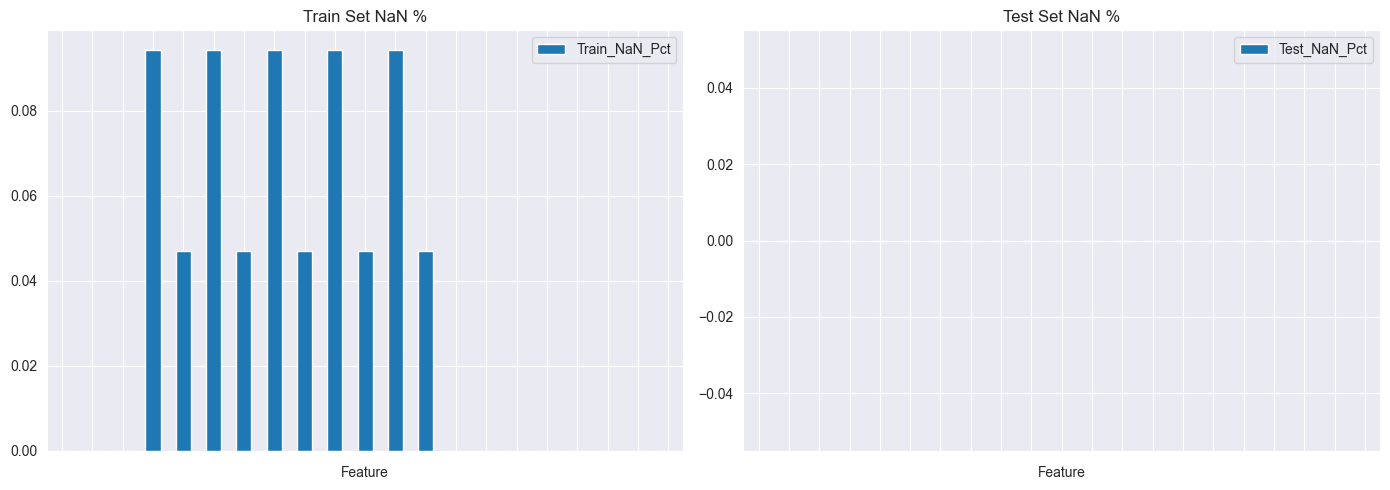

In [6]:
# Overall NaN summary
train_nan = train_df[config.ENGINEERED_FEATURE_COLS].isna().sum()
test_nan = test_df[config.ENGINEERED_FEATURE_COLS].isna().sum()

missing_summary = pd.DataFrame({
    'Feature': config.ENGINEERED_FEATURE_COLS,
    'Train_NaN_Count': train_nan.values,
    'Train_NaN_Pct': (train_nan / len(train_df) * 100).values,
    'Test_NaN_Count': test_nan.values,
    'Test_NaN_Pct': (test_nan / len(test_df) * 100).values
})

print("\nMissing Values Summary:")
print(missing_summary[missing_summary['Train_NaN_Count'] > 0])

# Visualize NaN patterns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
missing_summary.plot(x='Feature', y='Train_NaN_Pct', kind='bar', ax=axes[0], title='Train Set NaN %')
missing_summary.plot(x='Feature', y='Test_NaN_Pct', kind='bar', ax=axes[1], title='Test Set NaN %')
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
plt.tight_layout()

### 2.3 Basic Statistics by Feature Group

In [10]:
numerical_features = [f for f in config.ENGINEERED_FEATURE_COLS
                      if f not in [config.HOME_TEAM_COL, config.VISITOR_TEAM_COL, config.SEASON_COL]]

train_df[numerical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
home_win_pct_L10,21218.0,0.497839,0.206530,0.0000,0.400000,0.5000,0.6000,1.0000
away_win_pct_L10,21228.0,0.502291,0.205974,0.0000,0.400000,0.5000,0.6000,1.0000
home_fg_pct_L10,21218.0,0.453376,0.023574,0.3240,0.437700,0.4533,0.4688,0.5506
away_fg_pct_L10,21228.0,0.453412,0.023730,0.2920,0.437800,0.4531,0.4690,0.5469
home_fg3_pct_L10,21218.0,0.351602,0.041078,0.1270,0.325125,0.3519,0.3788,0.7000
away_fg3_pct_L10,21228.0,0.351718,0.040784,0.1000,0.325600,0.3524,0.3788,0.6670
home_ft_pct_L10,21218.0,0.755869,0.043091,0.5000,0.728500,0.7580,0.7856,0.8970
away_ft_pct_L10,21228.0,0.755911,0.042648,0.5445,0.728775,0.7580,0.7857,0.8930
home_pt_diff_L10,21218.0,-0.073474,5.944102,-22.8000,-4.100000,-0.1000,4.0000,22.2000
away_pt_diff_L10,21228.0,0.074258,5.915710,-24.0000,-3.900000,0.1000,4.1000,24.0000


### 2.4 Range Checks (outliers/infinite values)

In [11]:
# Check for infinities
inf_check = pd.DataFrame({
    'Feature': numerical_features,
    'Train_Inf': [np.isinf(train_df[f]).sum() for f in numerical_features],
    'Test_Inf': [np.isinf(test_df[f]).sum() for f in numerical_features]
})

if inf_check[['Train_Inf', 'Test_Inf']].sum().sum() > 0:
    print("[WARNING] Infinite values detected:")
    print(inf_check[inf_check[['Train_Inf', 'Test_Inf']].sum(axis=1) > 0])
else:
    print("[OK] No infinite values detected")

# Value ranges
print("\nFeature Value Ranges:")
for feature in numerical_features:
    train_range = f"[{train_df[feature].min():.3f}, {train_df[feature].max():.3f}]"
    test_range = f"[{test_df[feature].min():.3f}, {test_df[feature].max():.3f}]"
    print(f"{feature:30} Train: {train_range:20} Test: {test_range}")

[OK] No infinite values detected

Feature Value Ranges:
home_win_pct_L10               Train: [0.000, 1.000]       Test: [0.000, 1.000]
away_win_pct_L10               Train: [0.000, 1.000]       Test: [0.000, 1.000]
home_fg_pct_L10                Train: [0.324, 0.551]       Test: [0.392, 0.534]
away_fg_pct_L10                Train: [0.292, 0.547]       Test: [0.390, 0.534]
home_fg3_pct_L10               Train: [0.127, 0.700]       Test: [0.256, 0.468]
away_fg3_pct_L10               Train: [0.100, 0.667]       Test: [0.261, 0.474]
home_ft_pct_L10                Train: [0.500, 0.897]       Test: [0.623, 0.901]
away_ft_pct_L10                Train: [0.544, 0.893]       Test: [0.627, 0.909]
home_pt_diff_L10               Train: [-22.800, 22.200]    Test: [-21.900, 20.900]
away_pt_diff_L10               Train: [-24.000, 24.000]    Test: [-24.500, 20.900]
home_rest_days                 Train: [1.000, 250.000]     Test: [0.000, 277.000]
away_rest_days                 Train: [1.000, 251.000]  

## 3. Feature Distributions

### 3.1 Distributions by Feature Group

**Rolling Record Features:**

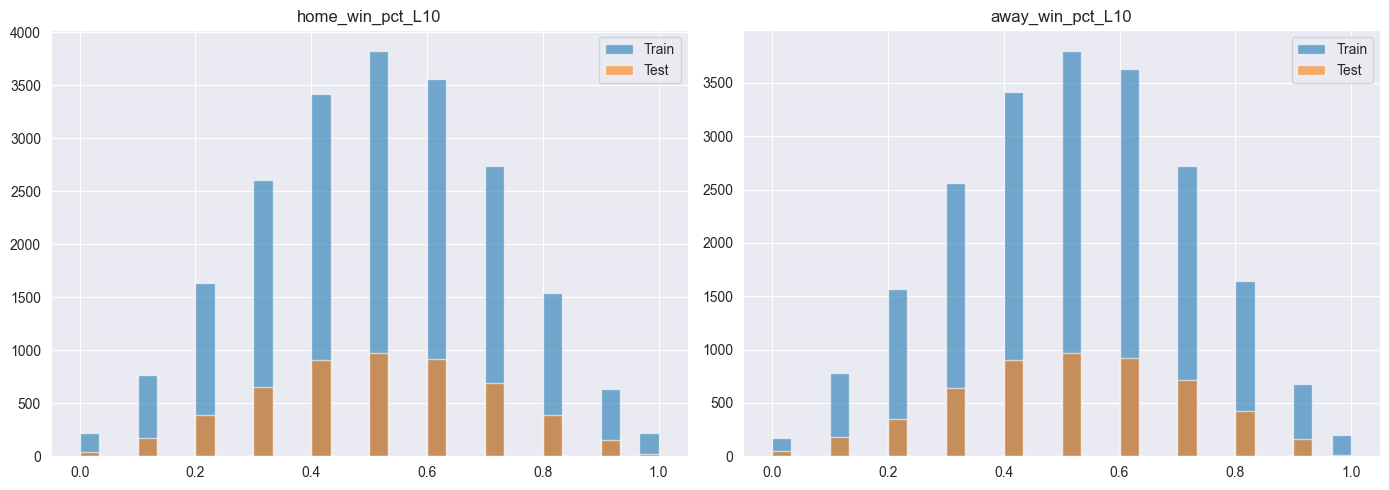

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, feature in enumerate(config.FEATURE_GROUPS['rolling_record']):
    train_df[feature].hist(bins=30, alpha=0.6, label='Train', ax=axes[i])
    test_df[feature].hist(bins=30, alpha=0.6, label='Test', ax=axes[i])
    axes[i].set_title(feature)
    axes[i].legend()
plt.tight_layout()

**Rolling Performance Features:**

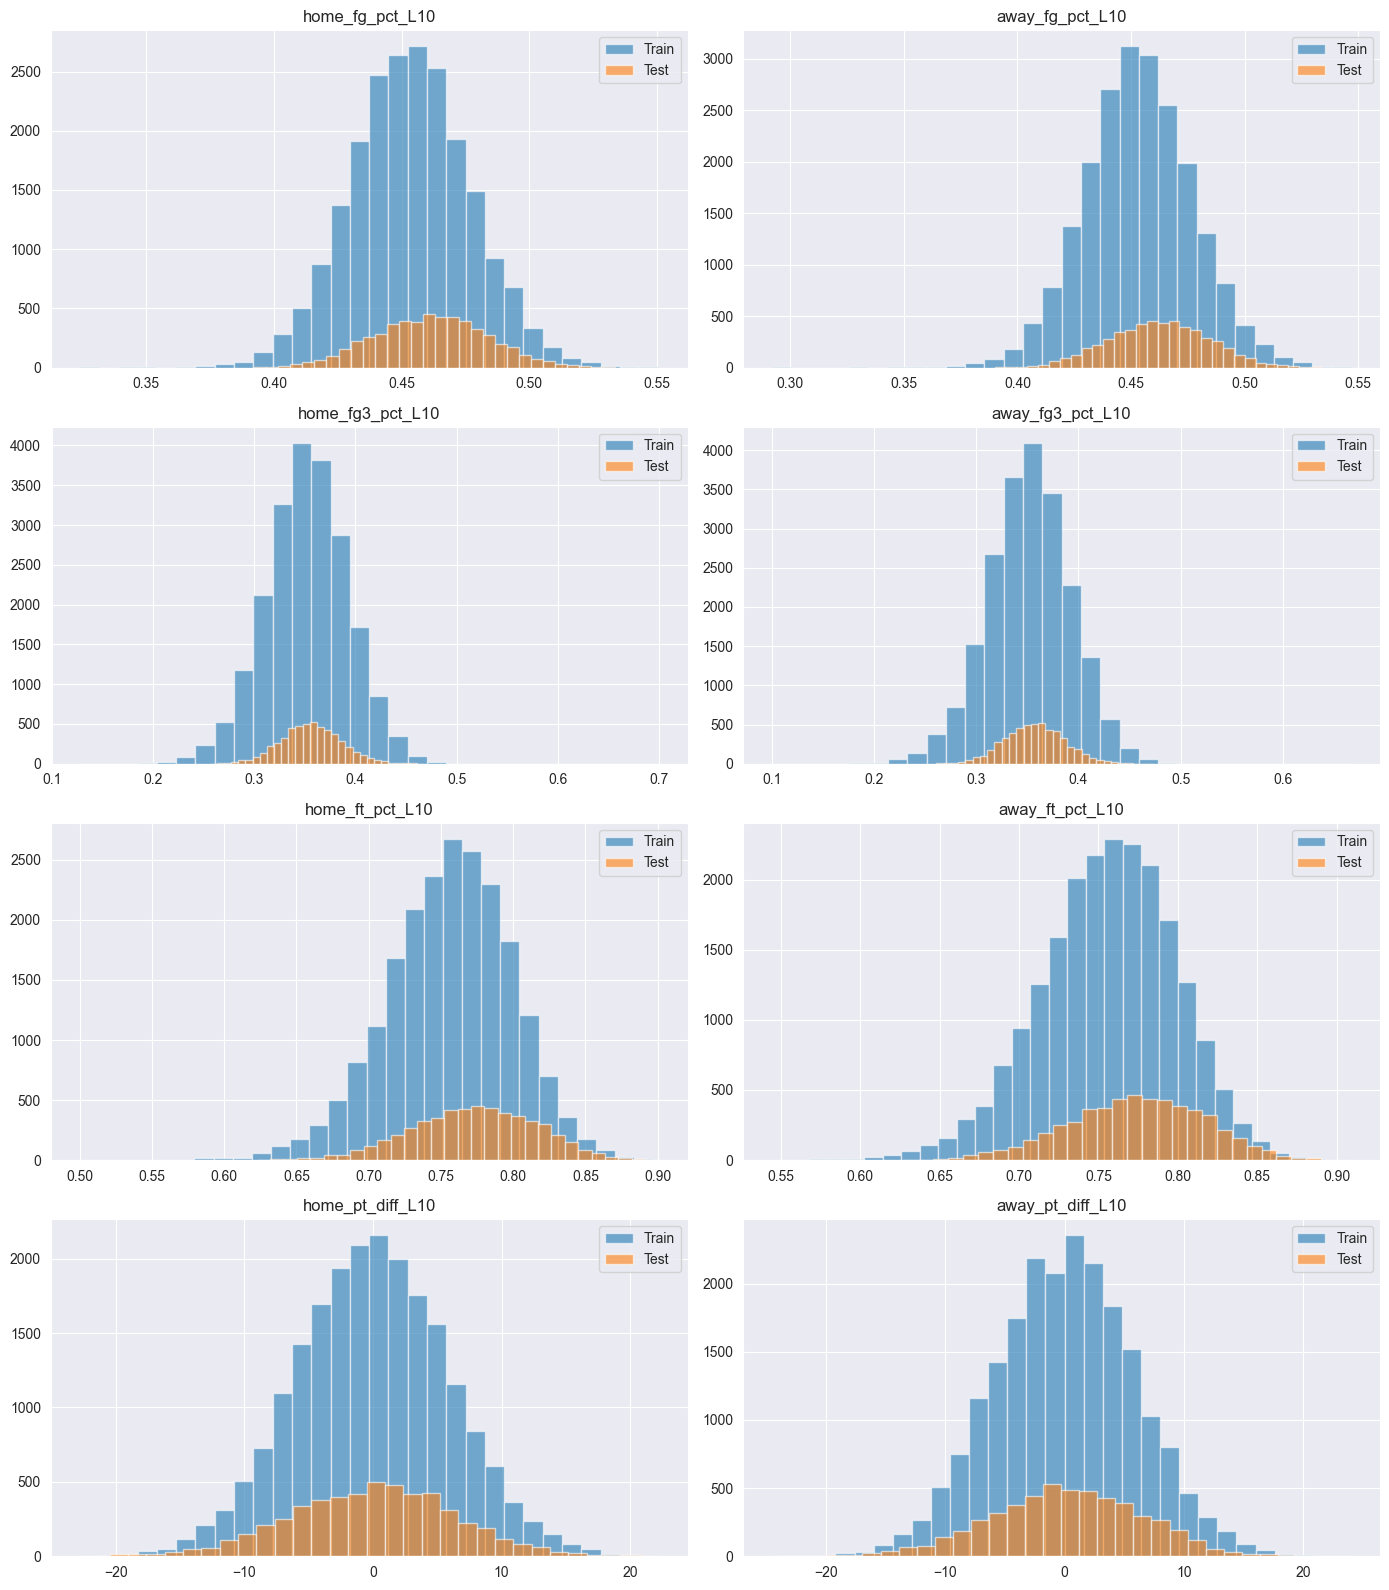

In [13]:
fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.flatten()
for i, feature in enumerate(config.FEATURE_GROUPS['rolling_performance']):
    train_df[feature].hist(bins=30, alpha=0.6, label='Train', ax=axes[i])
    test_df[feature].hist(bins=30, alpha=0.6, label='Test', ax=axes[i])
    axes[i].set_title(feature)
    axes[i].legend()
plt.tight_layout()

**Rest Features:**

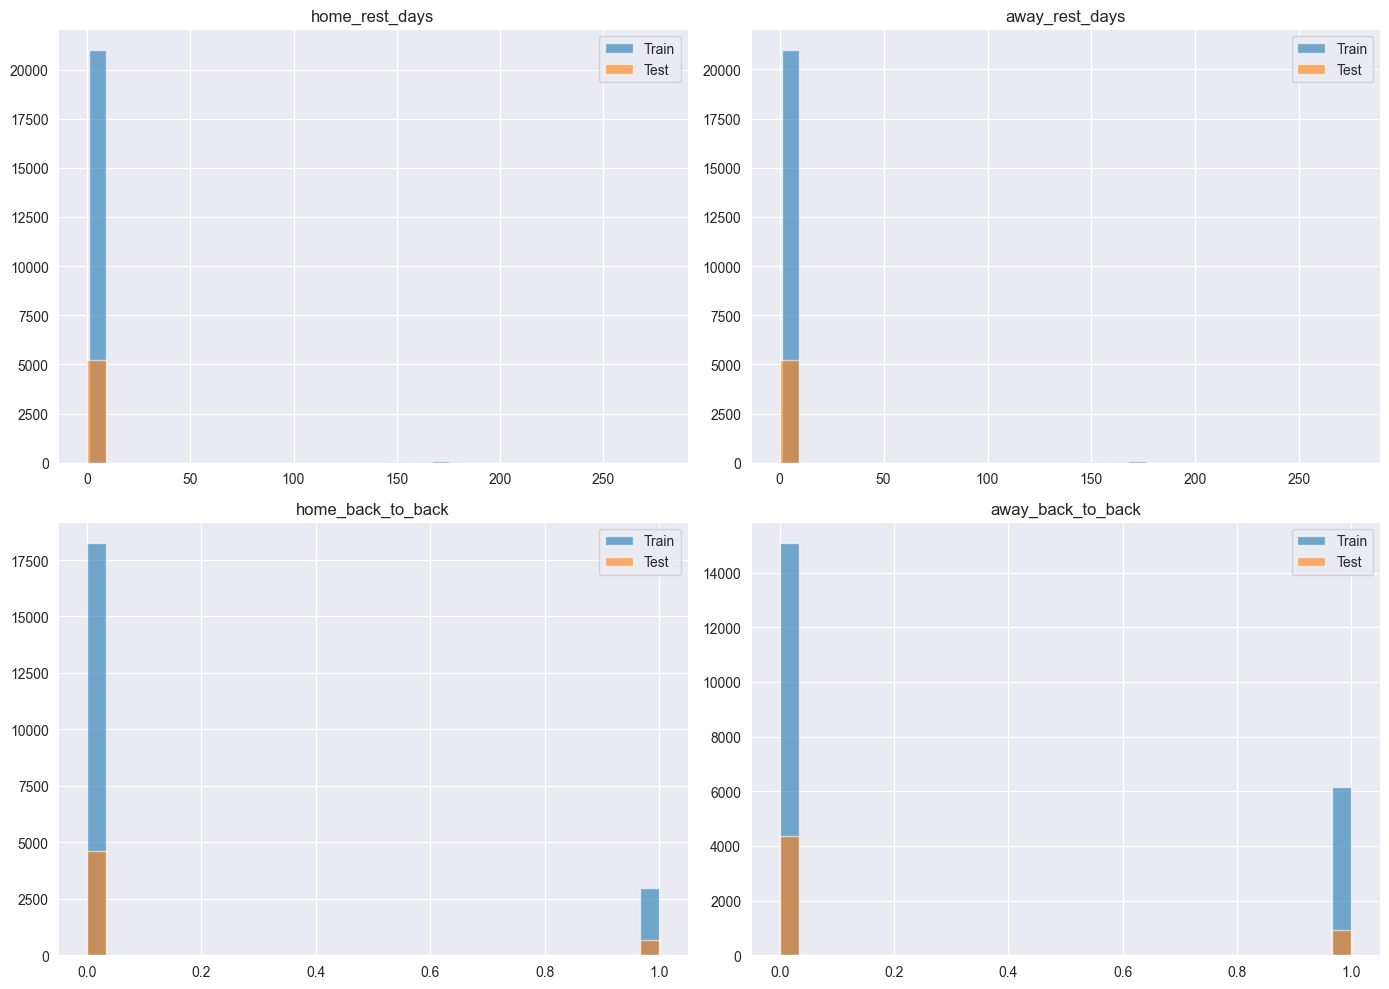

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
for i, feature in enumerate(config.FEATURE_GROUPS['rest']):
    train_df[feature].hist(bins=30, alpha=0.6, label='Train', ax=axes[i])
    test_df[feature].hist(bins=30, alpha=0.6, label='Test', ax=axes[i])
    axes[i].set_title(feature)
    axes[i].legend()
plt.tight_layout()

**Streak Features:**

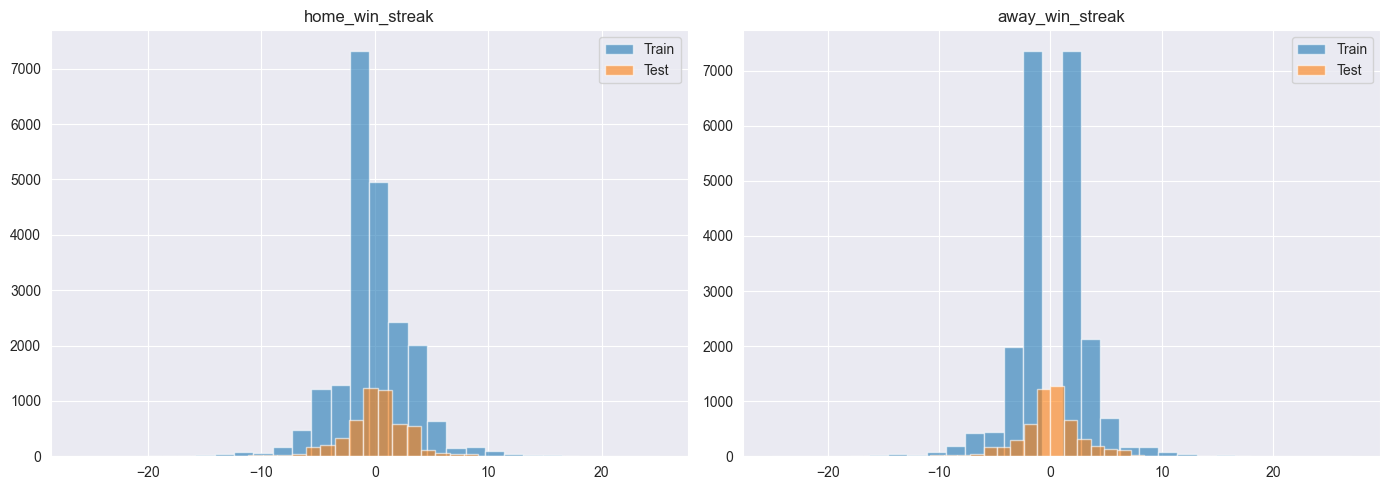

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, feature in enumerate(config.FEATURE_GROUPS['streak']):
    train_df[feature].hist(bins=30, alpha=0.6, label='Train', ax=axes[i])
    test_df[feature].hist(bins=30, alpha=0.6, label='Test', ax=axes[i])
    axes[i].set_title(feature)
    axes[i].legend()
plt.tight_layout()

**Head-to-Head Features:**

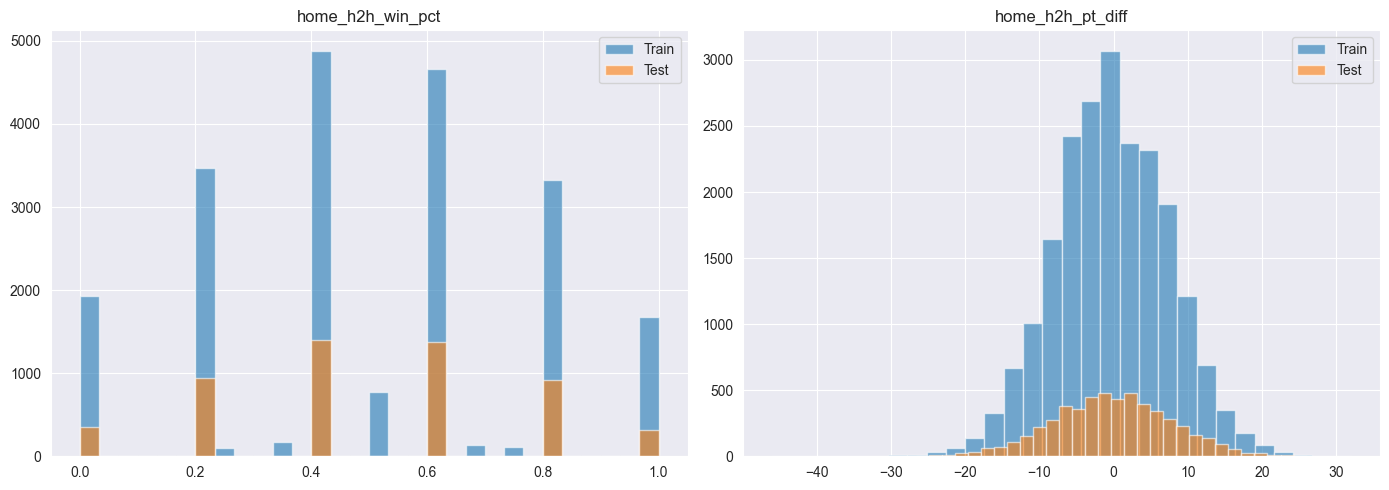

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, feature in enumerate(config.FEATURE_GROUPS['h2h']):
    train_df[feature].hist(bins=30, alpha=0.6, label='Train', ax=axes[i])
    test_df[feature].hist(bins=30, alpha=0.6, label='Test', ax=axes[i])
    axes[i].set_title(feature)
    axes[i].legend()
plt.tight_layout()

### 3.2 Box Plots for Outlier Detection

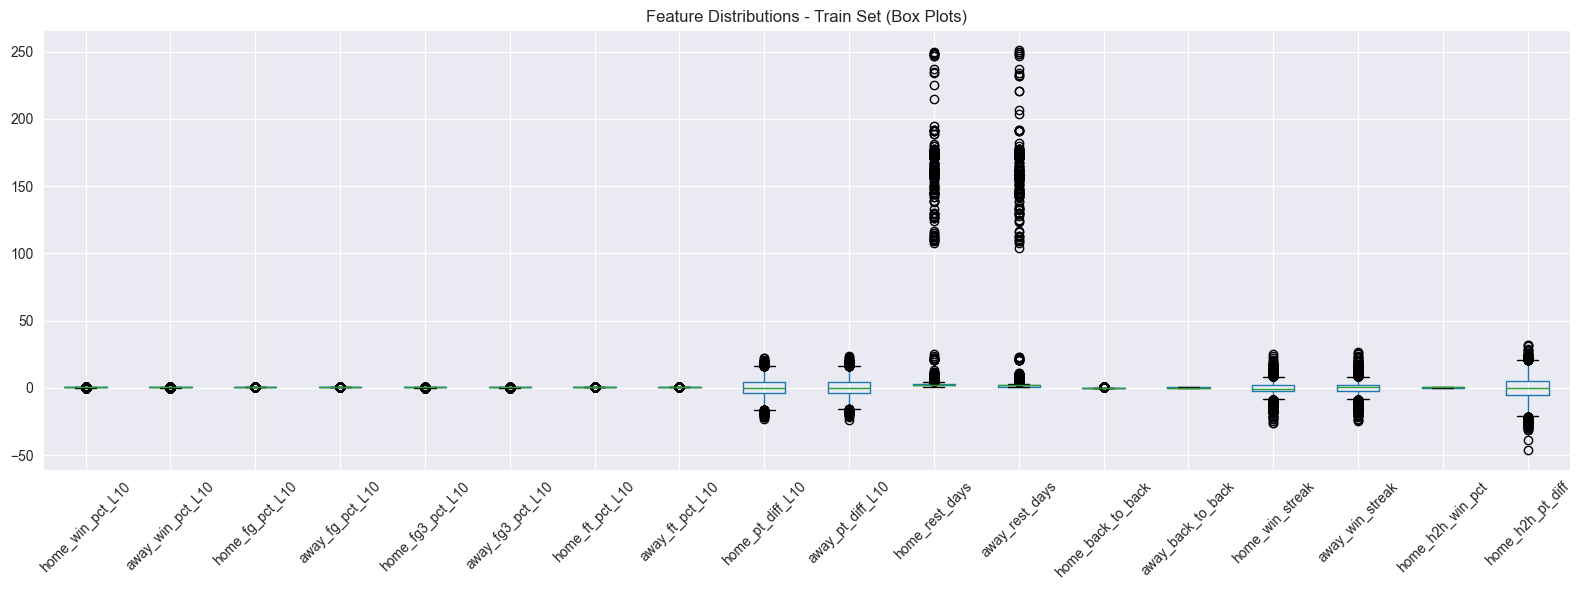

In [17]:
fig, ax = plt.subplots(figsize=(16, 6))
train_df[numerical_features].boxplot(ax=ax, rot=45)
ax.set_title('Feature Distributions - Train Set (Box Plots)')
plt.tight_layout()

## 4. Correlation Analysis

### 4.1 Correlation with Target Label


Top 10 Most Correlated Features:
              Feature  Correlation
8    home_pt_diff_L10     0.222492
17   home_h2h_pt_diff     0.212489
0    home_win_pct_L10     0.204521
16   home_h2h_win_pct     0.190482
14    home_win_streak     0.136648
2     home_fg_pct_L10     0.124676
4    home_fg3_pct_L10     0.070621
13  away_back_to_back     0.030409
6     home_ft_pct_L10     0.026563
10     home_rest_days    -0.005939


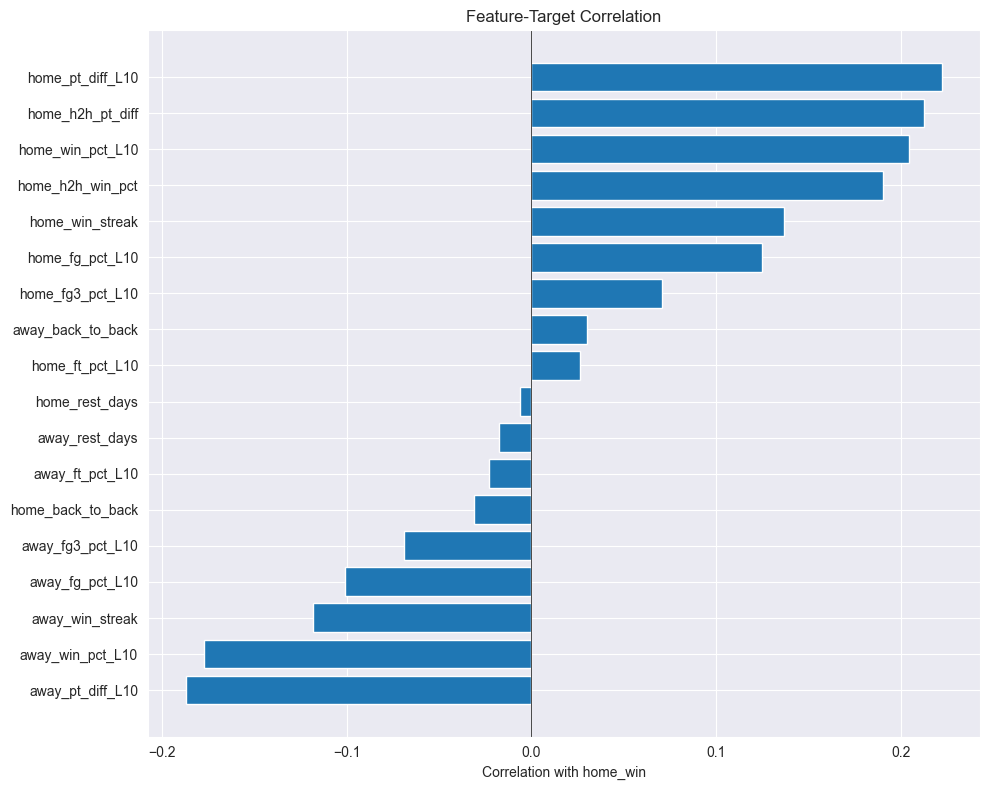

In [18]:
# Compute correlation with home_win
correlations = []
for feature in numerical_features:
    corr = train_df[[feature, config.LABEL_COL]].corr().iloc[0, 1]
    correlations.append({'Feature': feature, 'Correlation': corr})

corr_df = pd.DataFrame(correlations).sort_values('Correlation', ascending=False)

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(len(corr_df)), corr_df['Correlation'])
ax.set_yticks(range(len(corr_df)))
ax.set_yticklabels(corr_df['Feature'])
ax.set_xlabel('Correlation with home_win')
ax.set_title('Feature-Target Correlation')
ax.axvline(0, color='black', linewidth=0.5)
ax.invert_yaxis()
plt.tight_layout()

print("\nTop 10 Most Correlated Features:")
print(corr_df.head(10))

### 4.2 Feature Correlation Matrix

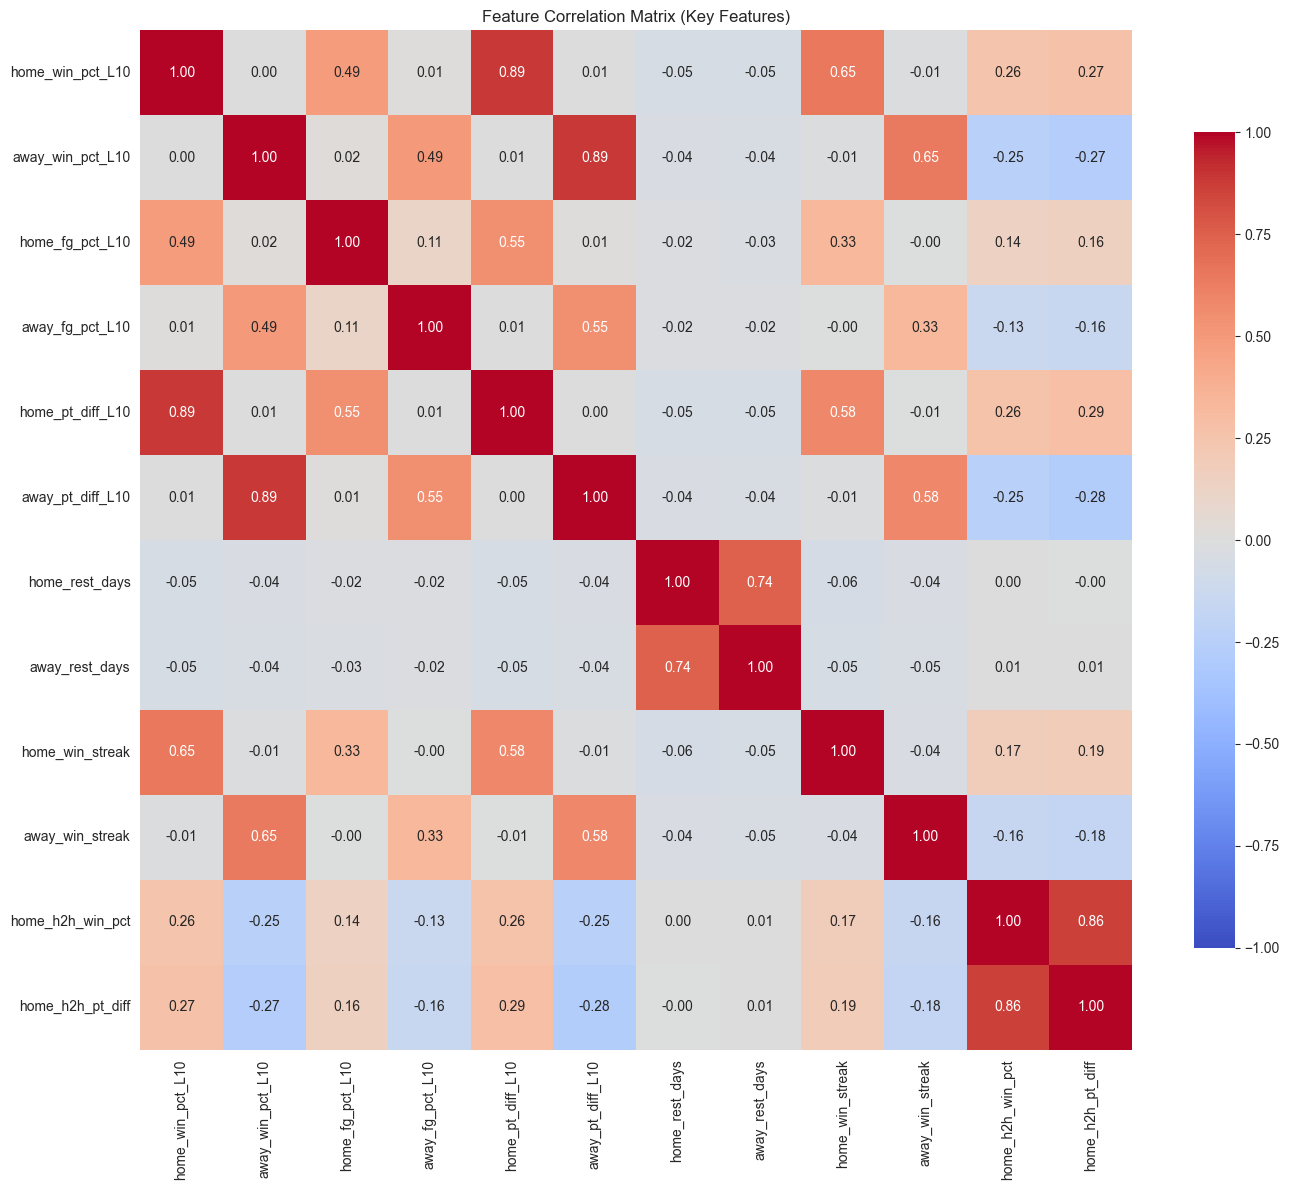

In [19]:
# Select key features for heatmap (avoid cluttering with all 21)
key_features = (
    config.FEATURE_GROUPS['rolling_record'] +
    ['home_fg_pct_L10', 'away_fg_pct_L10', 'home_pt_diff_L10', 'away_pt_diff_L10'] +
    ['home_rest_days', 'away_rest_days'] +
    config.FEATURE_GROUPS['streak'] +
    config.FEATURE_GROUPS['h2h']
)

# Compute correlation matrix
corr_matrix = train_df[key_features].corr()

# Heatmap
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, ax=ax, cbar_kws={'shrink': 0.8})
ax.set_title('Feature Correlation Matrix (Key Features)')
plt.tight_layout()

### 4.3 Home vs Away Feature Comparison

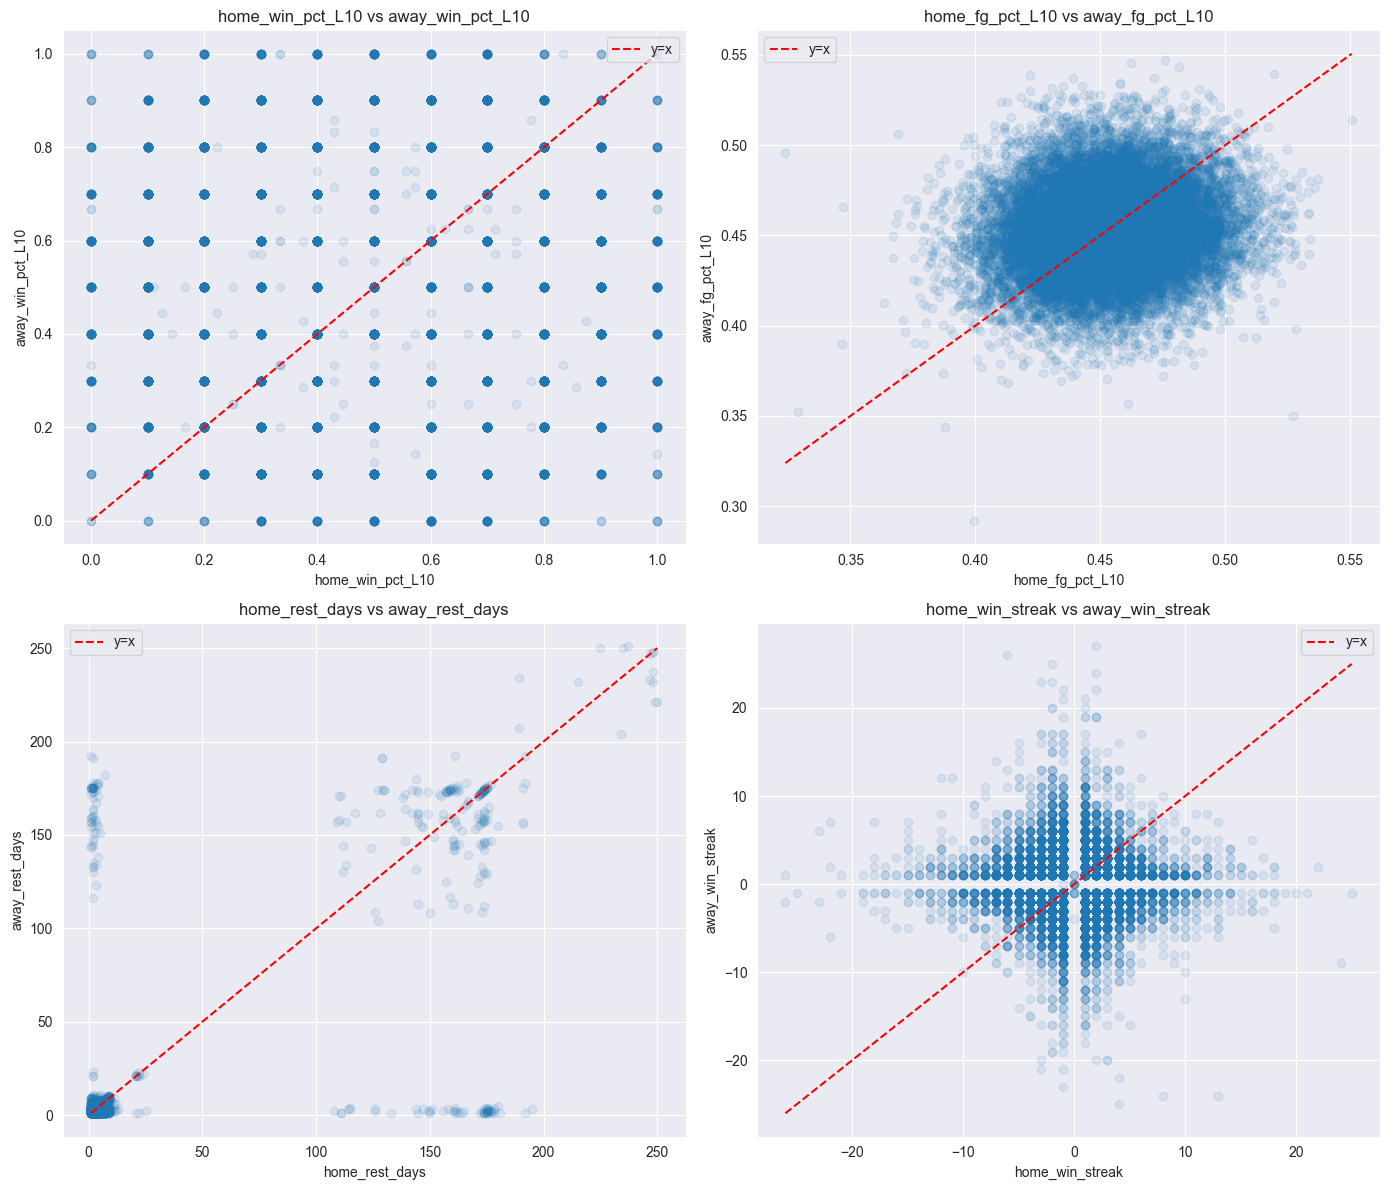

In [20]:
# Check if home/away pairs are symmetric
home_away_pairs = [
    ('home_win_pct_L10', 'away_win_pct_L10'),
    ('home_fg_pct_L10', 'away_fg_pct_L10'),
    ('home_rest_days', 'away_rest_days'),
    ('home_win_streak', 'away_win_streak')
]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, (home_feat, away_feat) in enumerate(home_away_pairs):
    axes[i].scatter(train_df[home_feat], train_df[away_feat], alpha=0.1)
    axes[i].plot([train_df[home_feat].min(), train_df[home_feat].max()],
                 [train_df[home_feat].min(), train_df[home_feat].max()],
                 'r--', label='y=x')
    axes[i].set_xlabel(home_feat)
    axes[i].set_ylabel(away_feat)
    axes[i].set_title(f'{home_feat} vs {away_feat}')
    axes[i].legend()

plt.tight_layout()

## 5. Feature Usefulness Analysis

### 5.1 Win Rate by Binned Feature Values


home_win_pct_L10:
                   mean  count
feature_bin                   
(-0.001, 0.2]  0.422374   2628
(0.2, 0.3]     0.500000   2610
(0.3, 0.4]     0.547258   3428
(0.4, 0.5]     0.608548   3837
(0.5, 0.6]     0.655751   3573
(0.6, 0.7]     0.697776   2743
(0.7, 0.8]     0.728036   1548
(0.8, 1.0]     0.782609    851

away_win_pct_L10:
                   mean  count
feature_bin                   
(-0.001, 0.2]  0.755441   2527
(0.2, 0.3]     0.673676   2568
(0.3, 0.4]     0.632194   3423
(0.4, 0.5]     0.597689   3808
(0.5, 0.6]     0.562225   3632
(0.6, 0.7]     0.520818   2738
(0.7, 0.8]     0.469338   1647
(0.8, 1.0]     0.410169    885

home_pt_diff_L10:


C:\Users\andre\AppData\Local\Temp\ipykernel_533260\3599201985.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rate_by_bin = df.groupby('feature_bin')[config.LABEL_COL].agg(['mean', 'count'])
C:\Users\andre\AppData\Local\Temp\ipykernel_533260\3599201985.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rate_by_bin = df.groupby('feature_bin')[config.LABEL_COL].agg(['mean', 'count'])
C:\Users\andre\AppData\Local\Temp\ipykernel_533260\3599201985.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

                                 mean  count
feature_bin                                 
(-22.801000000000002, -7.6]  0.396687   2173
(-7.6, -5.1]                 0.467757   2140
(-5.1, -3.2]                 0.521515   2138
(-3.2, -1.6]                 0.577661   2086
(-1.6, -0.1]                 0.577066   2154
(-0.1, 1.4]                  0.633396   2114
(1.4, 3.0]                   0.639903   2055
(3.0, 4.9]                   0.699858   2119
(4.9, 7.6]                   0.693187   2187
(7.6, 22.2]                  0.778265   2052

away_pt_diff_L10:
                     mean  count
feature_bin                     
(-24.001, -7.6]  0.758118   2125
(-7.6, -4.9]     0.698812   2188
(-4.9, -3.0]     0.653810   2100
(-3.0, -1.5]     0.642959   2095
(-1.5, 0.1]      0.616211   2233
(0.1, 1.6]       0.577244   2039
(1.6, 3.2]       0.546766   2149
(3.2, 5.1]       0.529412   2142
(5.1, 7.6]       0.499521   2086
(7.6, 24.0]      0.443747   2071

home_rest_days:
                  mean  coun

C:\Users\andre\AppData\Local\Temp\ipykernel_533260\3599201985.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rate_by_bin = df.groupby('feature_bin')[config.LABEL_COL].agg(['mean', 'count'])
C:\Users\andre\AppData\Local\Temp\ipykernel_533260\3599201985.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rate_by_bin = df.groupby('feature_bin')[config.LABEL_COL].agg(['mean', 'count'])
C:\Users\andre\AppData\Local\Temp\ipykernel_533260\3599201985.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

                     mean  count
feature_bin                     
(-26.001, -3.0]  0.475693   3353
(-3.0, -2.0]     0.581028   2530
(-2.0, -1.0]     0.600000   4795
(-1.0, 1.0]      0.599476   4961
(1.0, 2.0]       0.632922   2430
(2.0, 3.0]       0.677019   1288
(3.0, 25.0]      0.725678   1881


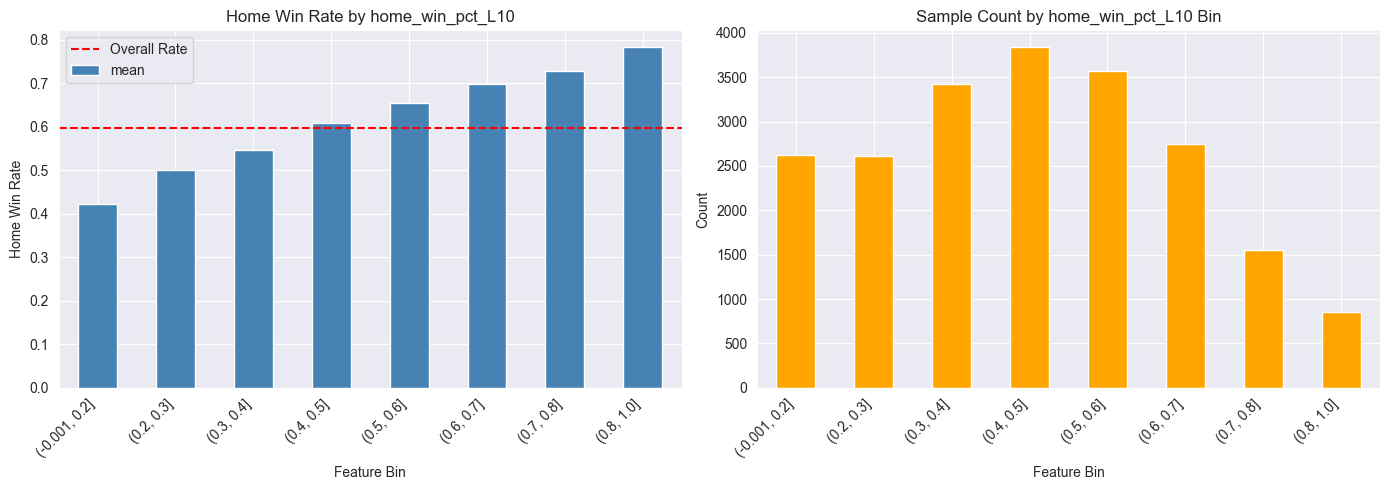

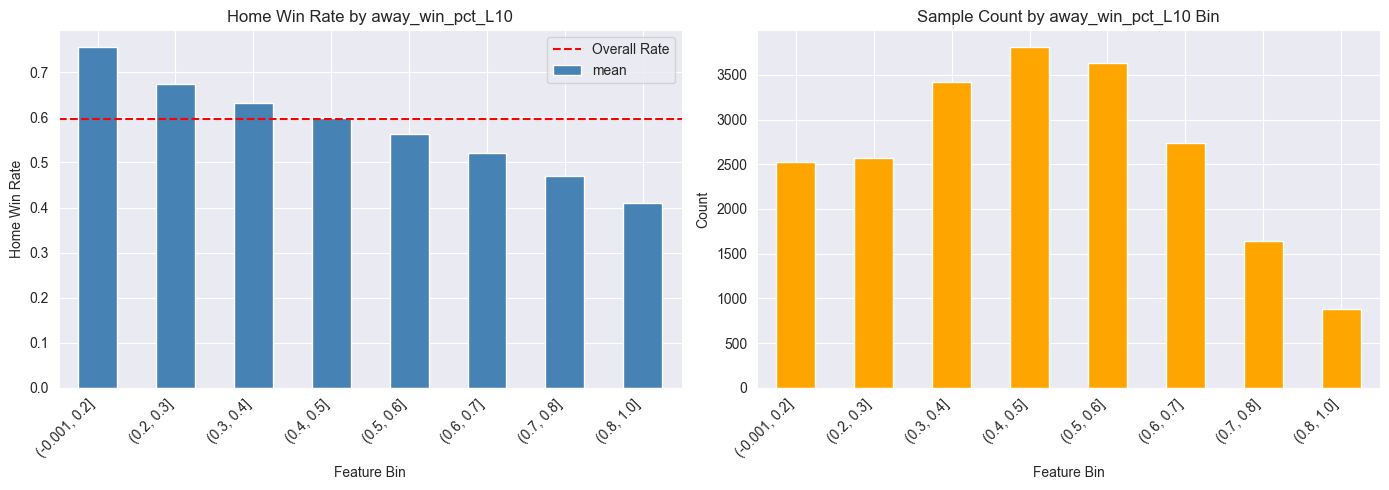

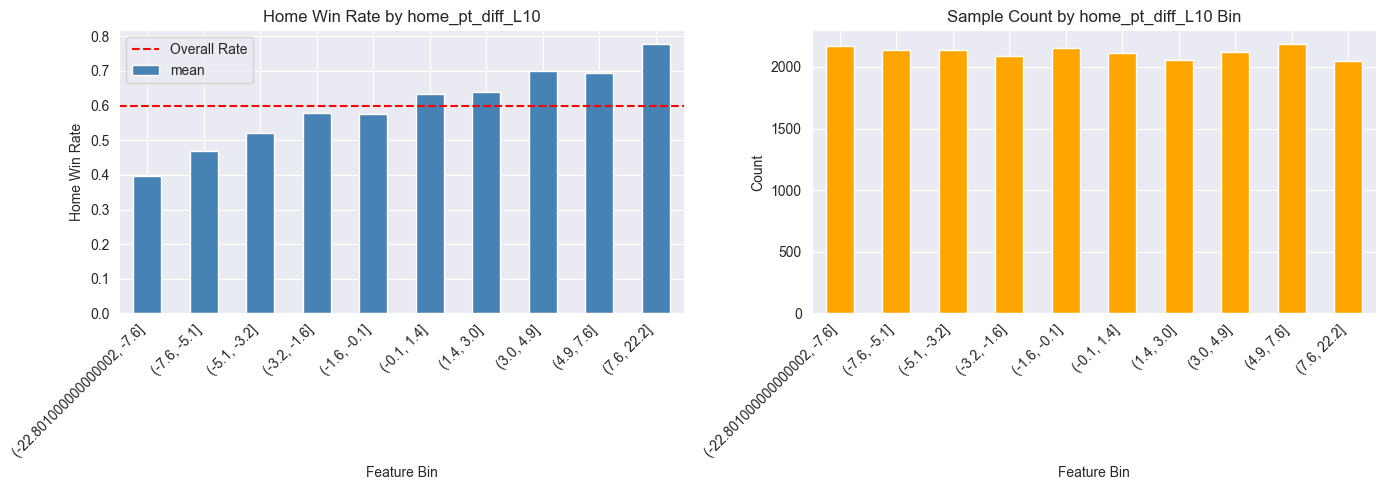

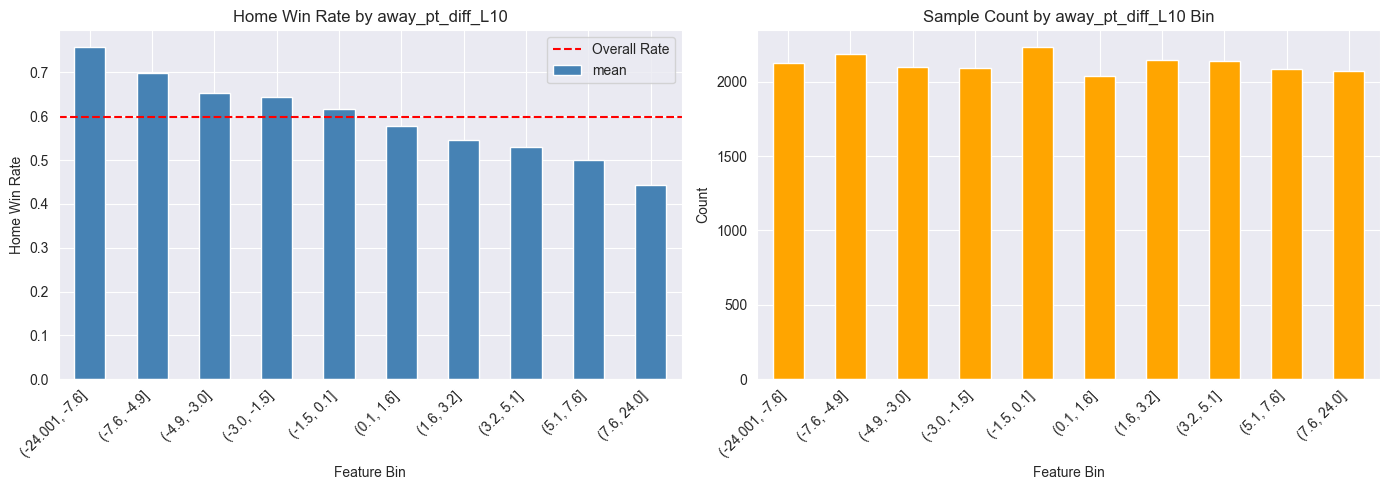

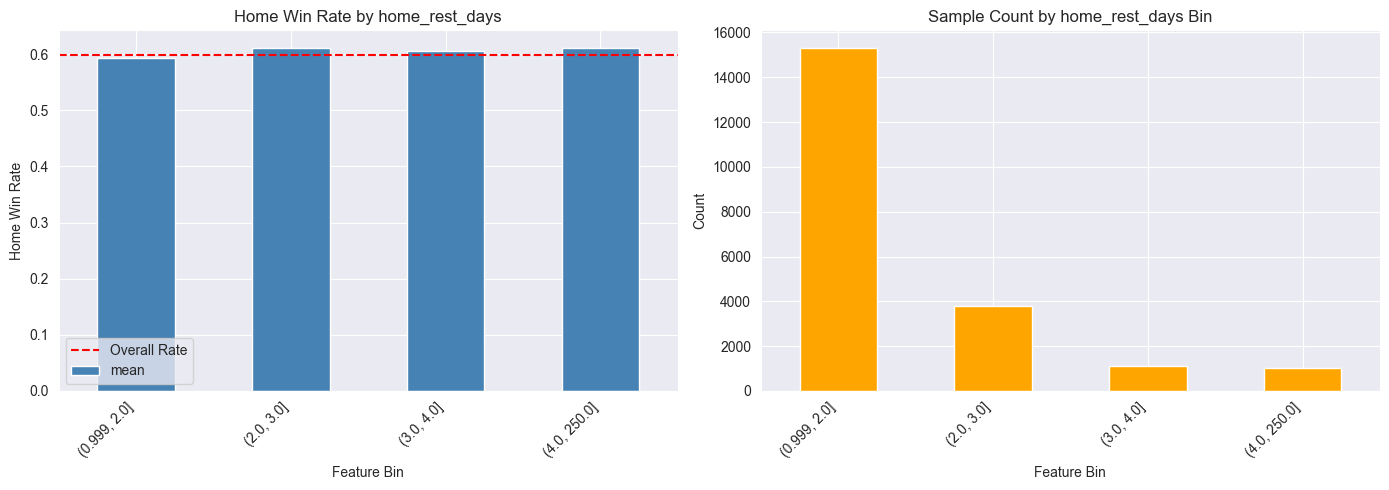

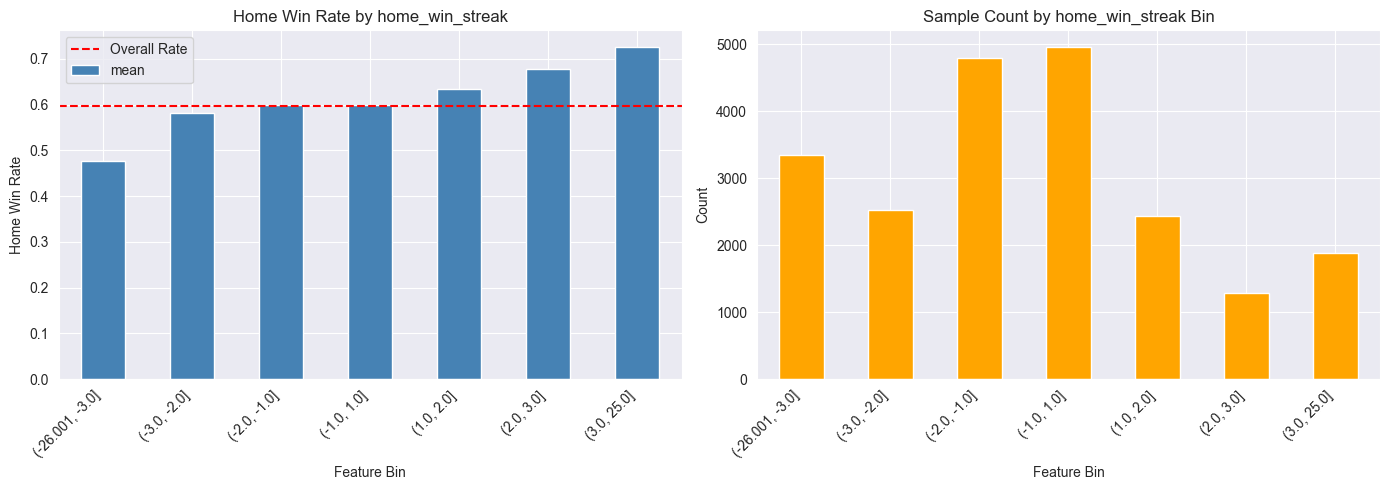

In [21]:
def plot_win_rate_by_feature_bins(df, feature, n_bins=10):
    """Plot home win rate across feature value bins."""
    df = df.copy()

    # Create bins
    df['feature_bin'] = pd.qcut(df[feature], q=n_bins, duplicates='drop')

    # Compute win rate per bin
    win_rate_by_bin = df.groupby('feature_bin')[config.LABEL_COL].agg(['mean', 'count'])

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Win rate
    win_rate_by_bin['mean'].plot(kind='bar', ax=axes[0], color='steelblue')
    axes[0].set_title(f'Home Win Rate by {feature}')
    axes[0].set_ylabel('Home Win Rate')
    axes[0].set_xlabel('Feature Bin')
    axes[0].axhline(df[config.LABEL_COL].mean(), color='red', linestyle='--', label='Overall Rate')
    axes[0].legend()
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

    # Sample counts
    win_rate_by_bin['count'].plot(kind='bar', ax=axes[1], color='orange')
    axes[1].set_title(f'Sample Count by {feature} Bin')
    axes[1].set_ylabel('Count')
    axes[1].set_xlabel('Feature Bin')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()

    return win_rate_by_bin

# Apply to key features
important_features = [
    'home_win_pct_L10',
    'away_win_pct_L10',
    'home_pt_diff_L10',
    'away_pt_diff_L10',
    'home_rest_days',
    'home_win_streak'
]

for feature in important_features:
    print(f"\n{feature}:")
    win_rate_by_bin = plot_win_rate_by_feature_bins(train_df, feature, n_bins=10)
    print(win_rate_by_bin)

## 6. Temporal Stability

### 6.1 Feature Trends Over Time

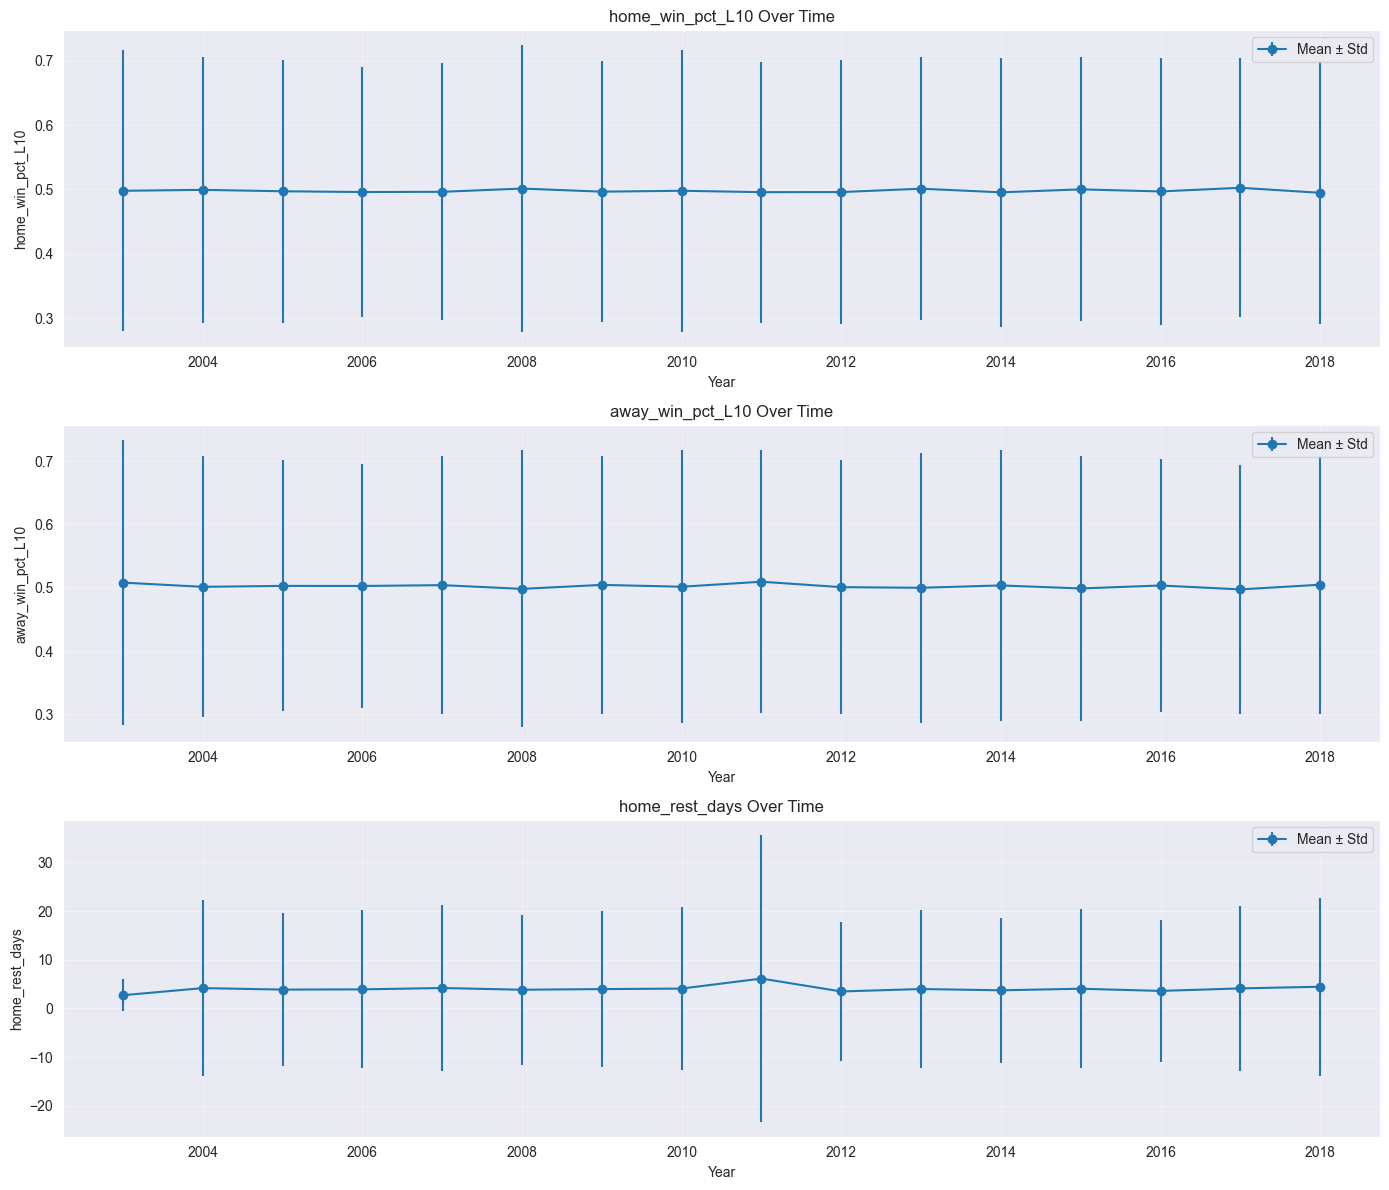

In [22]:
# Add year/month for temporal grouping
train_df['year'] = train_df[config.GAME_DATE_COL].dt.year
train_df['month'] = train_df[config.GAME_DATE_COL].dt.month

# Plot key features over time
key_temporal_features = ['home_win_pct_L10', 'away_win_pct_L10', 'home_rest_days']

fig, axes = plt.subplots(len(key_temporal_features), 1, figsize=(14, 12))

for i, feature in enumerate(key_temporal_features):
    temporal_stats = train_df.groupby('year')[feature].agg(['mean', 'std'])

    axes[i].errorbar(temporal_stats.index, temporal_stats['mean'],
                     yerr=temporal_stats['std'], marker='o', label='Mean ± Std')
    axes[i].set_title(f'{feature} Over Time')
    axes[i].set_ylabel(feature)
    axes[i].set_xlabel('Year')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()

### 6.2 Train vs Test Distribution Comparison

In [23]:
from scipy.stats import ks_2samp

print("Kolmogorov-Smirnov Test (Train vs Test):")
print("Null hypothesis: Distributions are the same\n")

for feature in numerical_features:
    train_vals = train_df[feature].dropna()
    test_vals = test_df[feature].dropna()

    statistic, pvalue = ks_2samp(train_vals, test_vals)

    significant = "***" if pvalue < 0.001 else ("**" if pvalue < 0.01 else ("*" if pvalue < 0.05 else ""))

    print(f"{feature:30} KS-stat: {statistic:.4f}  p-value: {pvalue:.4f} {significant}")

Kolmogorov-Smirnov Test (Train vs Test):
Null hypothesis: Distributions are the same

home_win_pct_L10               KS-stat: 0.0090  p-value: 0.8766 
away_win_pct_L10               KS-stat: 0.0121  p-value: 0.5606 
home_fg_pct_L10                KS-stat: 0.1509  p-value: 0.0000 ***
away_fg_pct_L10                KS-stat: 0.1651  p-value: 0.0000 ***
home_fg3_pct_L10               KS-stat: 0.1052  p-value: 0.0000 ***
away_fg3_pct_L10               KS-stat: 0.1102  p-value: 0.0000 ***
home_ft_pct_L10                KS-stat: 0.1583  p-value: 0.0000 ***
away_ft_pct_L10                KS-stat: 0.1641  p-value: 0.0000 ***
home_pt_diff_L10               KS-stat: 0.0233  p-value: 0.0196 *
away_pt_diff_L10               KS-stat: 0.0270  p-value: 0.0041 **
home_rest_days                 KS-stat: 0.0335  p-value: 0.0001 ***
away_rest_days                 KS-stat: 0.1073  p-value: 0.0000 ***
home_back_to_back              KS-stat: 0.0094  p-value: 0.8446 
away_back_to_back              KS-stat: 0.

## 7. Model Integration (Optional)

### 7.1 Load Best Model

In [24]:
model = joblib.load(config.MODEL_V1_1_PATH)
print(f"Loaded model: {type(model.named_steps['classifier'])}")

Loaded model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>


### 7.2 Feature Importance Analysis


Top 10 Most Important Features:
                  Feature  Importance
84  num__home_pt_diff_L10    0.128199
93  num__home_h2h_pt_diff    0.116177
85  num__away_pt_diff_L10    0.105624
76  num__home_win_pct_L10    0.073283
92  num__home_h2h_win_pct    0.060207
77  num__away_win_pct_L10    0.053990
78   num__home_fg_pct_L10    0.051492
79   num__away_fg_pct_L10    0.040436
90   num__home_win_streak    0.034201
80  num__home_fg3_pct_L10    0.033757


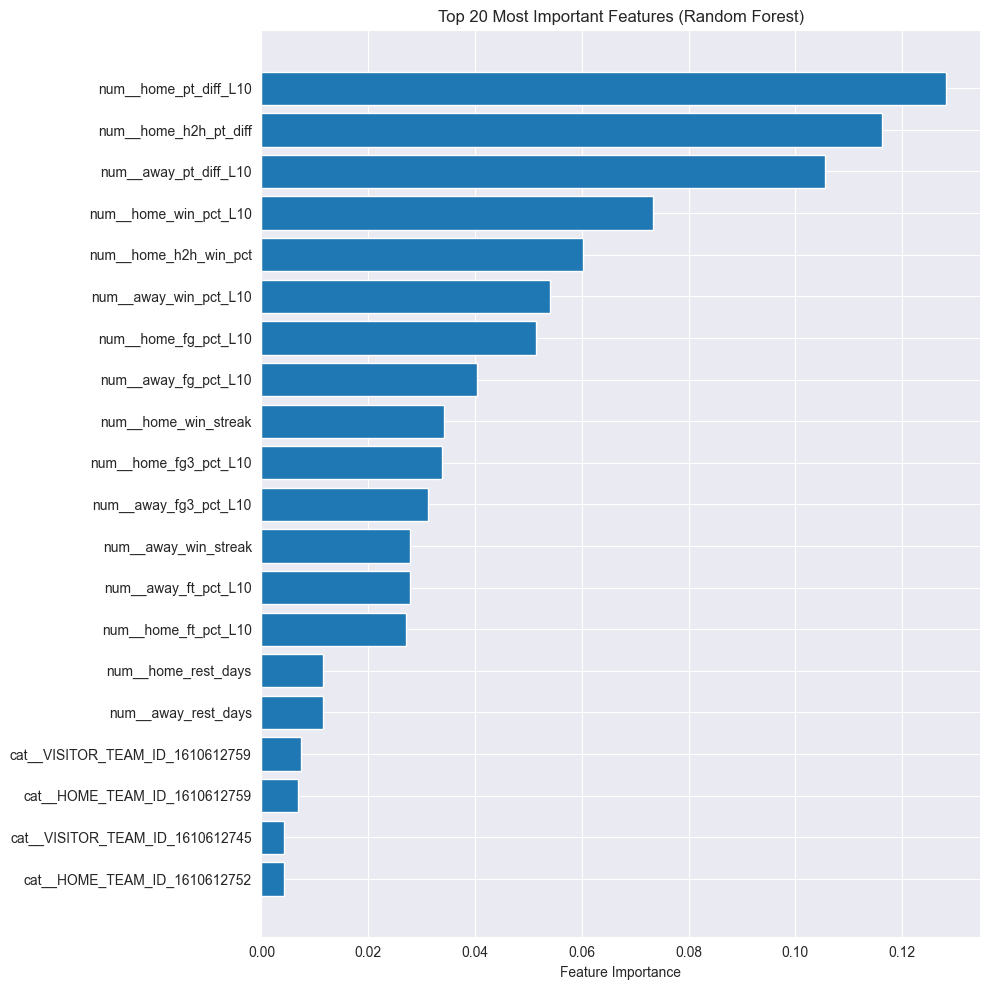

In [25]:
# Extract feature importance from Random Forest
classifier = model.named_steps['classifier']

if hasattr(classifier, 'feature_importances_'):
    # Get feature names after preprocessing
    preprocessor = model.named_steps['preprocessor']
    feature_names_transformed = preprocessor.get_feature_names_out()

    # Create importance dataframe
    importance_df = pd.DataFrame({
        'Feature': feature_names_transformed,
        'Importance': classifier.feature_importances_
    }).sort_values('Importance', ascending=False)

    # Plot top 20
    fig, ax = plt.subplots(figsize=(10, 10))
    top_20 = importance_df.head(20)
    ax.barh(range(len(top_20)), top_20['Importance'])
    ax.set_yticks(range(len(top_20)))
    ax.set_yticklabels(top_20['Feature'])
    ax.set_xlabel('Feature Importance')
    ax.set_title('Top 20 Most Important Features (Random Forest)')
    ax.invert_yaxis()
    plt.tight_layout()

    print("\nTop 10 Most Important Features:")
    print(importance_df.head(10))

### 7.3 Calibration Analysis


Calibration Analysis:
Bin 1: Predicted=0.278, Actual=0.250
Bin 2: Predicted=0.365, Actual=0.291
Bin 3: Predicted=0.454, Actual=0.393
Bin 4: Predicted=0.553, Actual=0.506
Bin 5: Predicted=0.649, Actual=0.620
Bin 6: Predicted=0.744, Actual=0.717
Bin 7: Predicted=0.820, Actual=0.779


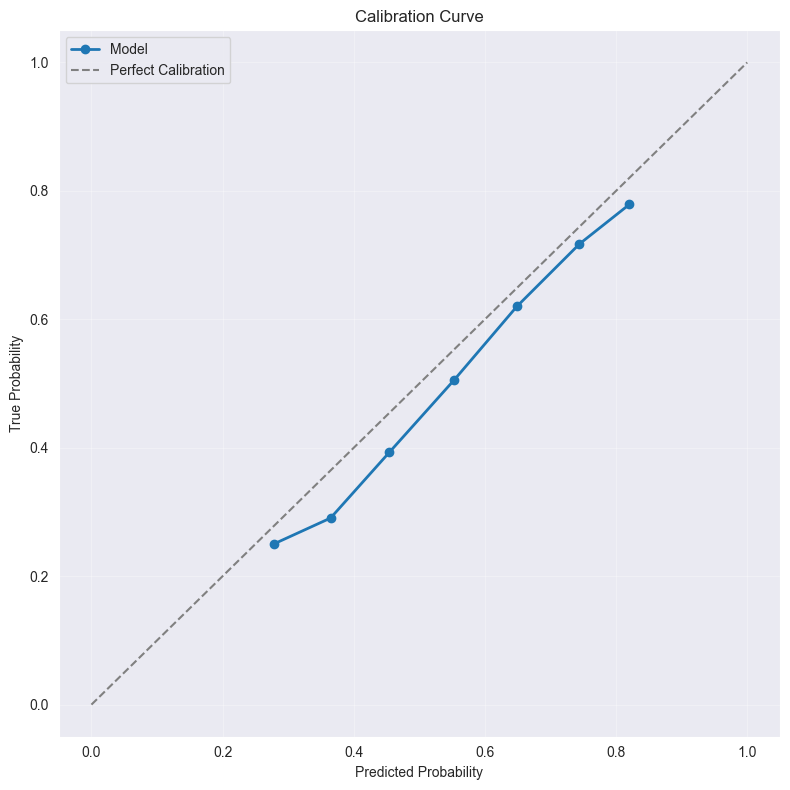

In [26]:
from sklearn.calibration import calibration_curve

# Get predictions
X_test = test_df[config.ENGINEERED_FEATURE_COLS]
y_test = test_df[config.LABEL_COL]
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Model')
ax.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Calibration')
ax.set_xlabel('Predicted Probability')
ax.set_ylabel('True Probability')
ax.set_title('Calibration Curve')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()

print("\nCalibration Analysis:")
for i in range(len(prob_pred)):
    print(f"Bin {i+1}: Predicted={prob_pred[i]:.3f}, Actual={prob_true[i]:.3f}")

### 7.4 Error Analysis by Feature Values


Error Analysis:
Overall Accuracy: 0.616

Confident but Wrong: 321 games (6.04%)


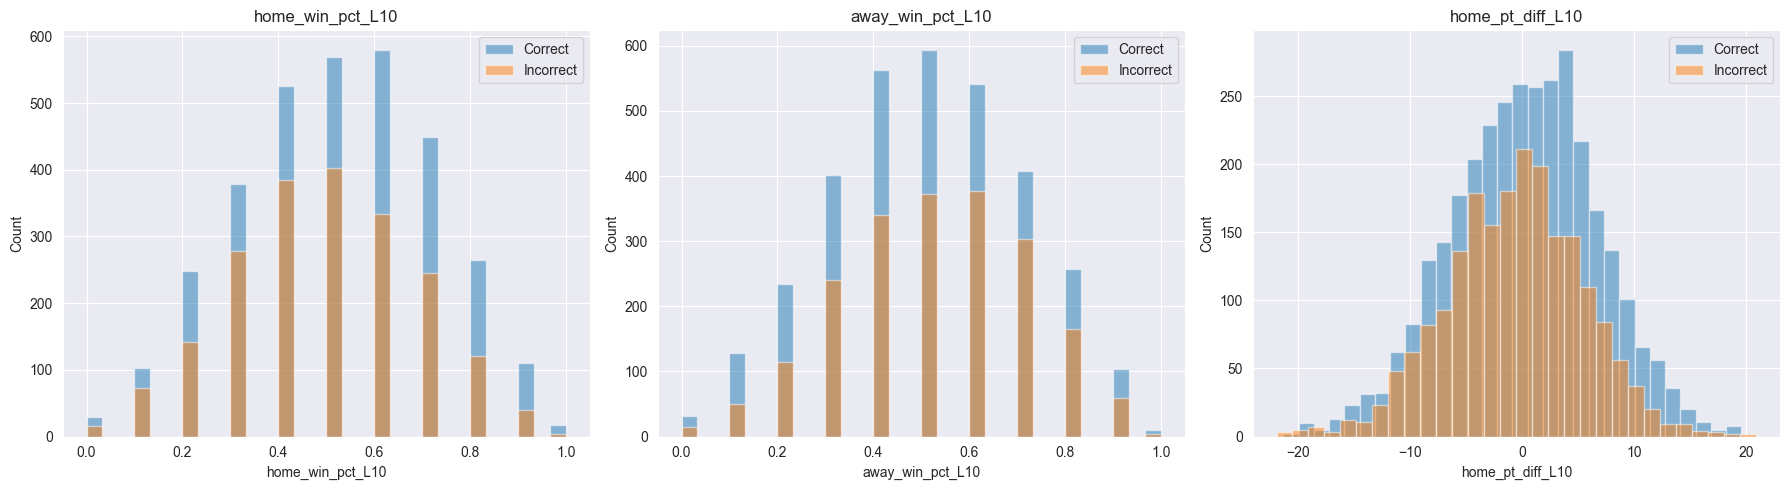

In [27]:
# Add predictions to test set
test_df['predicted_prob'] = y_pred_proba
test_df['predicted_label'] = (y_pred_proba >= 0.5).astype(int)
test_df['correct'] = (test_df['predicted_label'] == test_df[config.LABEL_COL])

# Analyze errors by feature values
print("\nError Analysis:")
print(f"Overall Accuracy: {test_df['correct'].mean():.3f}")

# Find games where model was very confident but wrong
confident_wrong = test_df[
    (~test_df['correct']) &
    ((test_df['predicted_prob'] > 0.7) | (test_df['predicted_prob'] < 0.3))
]

print(f"\nConfident but Wrong: {len(confident_wrong)} games ({len(confident_wrong)/len(test_df)*100:.2f}%)")

# Feature distributions for correct vs incorrect predictions
key_features_for_error = ['home_win_pct_L10', 'away_win_pct_L10', 'home_pt_diff_L10']

fig, axes = plt.subplots(1, len(key_features_for_error), figsize=(18, 5))

for i, feature in enumerate(key_features_for_error):
    test_df[test_df['correct']][feature].hist(bins=30, alpha=0.5, label='Correct', ax=axes[i])
    test_df[~test_df['correct']][feature].hist(bins=30, alpha=0.5, label='Incorrect', ax=axes[i])
    axes[i].set_title(f'{feature}')
    axes[i].legend()
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')

plt.tight_layout()

## 8. Summary and Insights

In [28]:
print("=" * 80)
print("FEATURE INSPECTION SUMMARY")
print("=" * 80)

print(f"\nDataset Statistics:")
print(f"  Train: {len(train_df):,} games")
print(f"  Test:  {len(test_df):,} games")
print(f"  Features: {len(config.ENGINEERED_FEATURE_COLS)}")

print(f"\nFeature Quality:")
print(f"  Missing values: {(train_df[config.ENGINEERED_FEATURE_COLS].isna().sum().sum() / (len(train_df) * len(config.ENGINEERED_FEATURE_COLS)) * 100):.2f}%")
print(f"  Infinite values: {np.isinf(train_df[numerical_features]).sum().sum()}")

print(f"\nMost Correlated Features with Target:")
print(corr_df.head(5).to_string(index=False))

if 'importance_df' in locals():
    print(f"\nMost Important Features (Model):")
    print(importance_df.head(5).to_string(index=False))

print("\n" + "=" * 80)
print("Next Steps:")
print("  - Feature engineering refinements based on correlation insights")
print("  - Feature selection/ablation studies")
print("  - Investigate temporal trends for stability")
print("  - Hyperparameter tuning with validated features")
print("=" * 80)

FEATURE INSPECTION SUMMARY

Dataset Statistics:
  Train: 21,238 games
  Test:  5,314 games
  Features: 21

Feature Quality:
  Missing values: 0.03%
  Infinite values: 0

Most Correlated Features with Target:
         Feature  Correlation
home_pt_diff_L10     0.222492
home_h2h_pt_diff     0.212489
home_win_pct_L10     0.204521
home_h2h_win_pct     0.190482
 home_win_streak     0.136648

Most Important Features (Model):
              Feature  Importance
num__home_pt_diff_L10    0.128199
num__home_h2h_pt_diff    0.116177
num__away_pt_diff_L10    0.105624
num__home_win_pct_L10    0.073283
num__home_h2h_win_pct    0.060207

Next Steps:
  - Feature engineering refinements based on correlation insights
  - Feature selection/ablation studies
  - Investigate temporal trends for stability
  - Hyperparameter tuning with validated features
